In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers.legacy import RMSprop

from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

## global variables

In [2]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv'

time_step = 24
evaluation_results = []

# model specification
neurons = 250
epochs = 10
batch_size = 64

## helper functions

In [3]:
# Modified evaluate_model function to store results in evaluation_results
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# def build_bilstm_model(time_step):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, 1))))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
#     model.add(Dropout(0.2))
#     model.add(Dense(1)) # output layer
#     # Compile the model
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

def build_bilstm_model(params, time_step):
    model = Sequential([
        Bidirectional(LSTM(params['neurons'], activation=params['activation'], return_sequences=True, 
                           input_shape=(time_step, 1))),
        Dropout(params['dropout_rate']),
        Bidirectional(LSTM(params['neurons'], activation=params['activation'], return_sequences=False)),
        Dropout(params['dropout_rate']),
        Dense(1, activation=params['output_activation'])
    ])
    optimizer = Adam(learning_rate=params['learning_rate']) if params['optimizer'] == 'adam' else RMSprop(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Fitness function to evaluate a whale's performance
def fitness_function(params, x_train, y_train, x_val, y_val, time_step):
    model = build_bilstm_model(params, time_step)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64, verbose=0)
    return min(history.history['val_loss'])

# Define the WOA algorithm
def whale_optimization_algorithm(x_train, y_train, x_val, y_val, time_step, search_space, population_size, iterations):
    # Split numeric and categorical parameters
    numeric_keys = [key for key, values in search_space.items() if isinstance(values[0], (int, float))]
    categorical_keys = [key for key in search_space if key not in numeric_keys]
    
    # Initialize population (whales) randomly
    population = [
        {key: random.choice(values) for key, values in search_space.items()} for _ in range(population_size)
    ]
    
    # Evaluate initial fitness
    fitness = [fitness_function(individual, x_train, y_train, x_val, y_val, time_step) for individual in population]
    
    # Determine the best whale (lowest loss)
    best_idx = np.argmin(fitness)
    best_whale = population[best_idx]
    
    # WOA main loop
    for iter in range(iterations):
        a = 2 - iter * (2 / iterations)  # Linearly decreasing 'a'
        
        for i in range(population_size):
            r = np.random.rand()
            A = 2 * a * r - a
            C = 2 * np.random.rand()
            p = np.random.rand()
            
            # Update numeric parameters
            if p < 0.5:
                if abs(A) < 1:
                    # Encircling prey
                    D = {key: abs(C * best_whale[key] - population[i][key]) for key in numeric_keys}
                    for key in numeric_keys:
                        population[i][key] = best_whale[key] - A * D[key]
                else:
                    # Searching for prey
                    random_whale = population[np.random.randint(0, population_size)]
                    D = {key: abs(C * random_whale[key] - population[i][key]) for key in numeric_keys}
                    for key in numeric_keys:
                        population[i][key] = random_whale[key] - A * D[key]
            else:
                # Bubble-net attacking
                D = {key: abs(best_whale[key] - population[i][key]) for key in numeric_keys}
                for key in numeric_keys:
                    population[i][key] = D[key] * np.exp(-1 * iter) * np.cos(2 * np.pi * iter)
            
            # Ensure numeric parameters are valid
            for key in numeric_keys:
                if key in ['neurons']:  # Ensure integer parameters
                    population[i][key] = int(np.clip(population[i][key], min(search_space[key]), max(search_space[key])))
                else:  # Float parameters like dropout rates
                    population[i][key] = np.clip(population[i][key], min(search_space[key]), max(search_space[key]))
            
            # Update categorical parameters randomly
            for key in categorical_keys:
                if p < 0.5 and abs(A) < 1:
                    population[i][key] = best_whale[key]
                else:
                    population[i][key] = random.choice(search_space[key])
        
        # Evaluate new fitness
        fitness = [fitness_function(individual, x_train, y_train, x_val, y_val, time_step) for individual in population]
        
        # Update the best whale
        best_idx = np.argmin(fitness)
        best_whale = population[best_idx]
        
        # Logging progress
        print(f"Iteration {iter + 1}/{iterations}, Best Loss: {min(fitness)}")
    
    return best_whale



# Define the hyperparameter search space
search_space = {
    'neurons': [50, 100, 200, 300],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'activation': ['relu', 'tanh'],
    'output_activation': ['linear', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [1e-4, 1e-3, 1e-2]
}

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Base BiLSTM

In [4]:
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

data = data[(data.index.month.isin([5, 6, 7])) & (data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# Set time_step (lookback window for BiLSTM)
time_step = 24  # Predict based on past 24 hours (1 day)
X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_25312/572481565.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


dataset shape (8832, 5)
X, y shape (8808, 24, 5) (8808,)


In [5]:
print("Training BiLSTM only...")
print("\n")

best_params = whale_optimization_algorithm(X_train, y_train, X_test, y_test, time_step, search_space, population_size=10, iterations=20)

print("Best Hyperparameters:", best_params)

model = build_bilstm_model(best_params, time_step)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

y_train_predict = scaler.inverse_transform(
    np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_predict = scaler.inverse_transform(
    np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

evaluate_model(y_train_actual, y_train_predict, 'BiLSTM', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'BiLSTM', 'Testing')

Training BiLSTM only...




KeyboardInterrupt: 

In [ ]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,167.318890,111672.436334,334.174260,0.918587
1,BiLSTM,Testing,180.141856,120824.007370,347.597479,0.900717


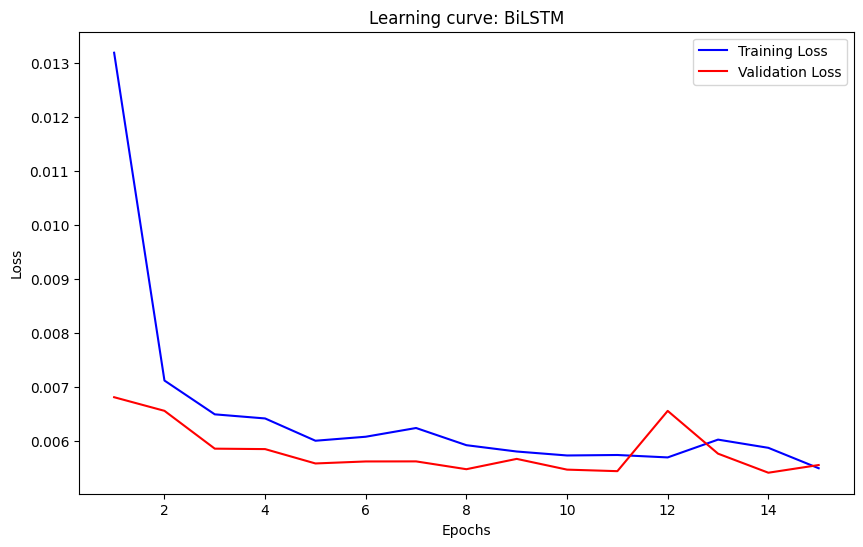

In [ ]:
plot_learning_curve(history, 'BiLSTM')

## GBDT-BiLSTM

In [ ]:
# Load and split data
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])
data = data[(data.index.month.isin([5, 6, 7])) & (data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]

X = dataset.iloc[:, 1:].values  # Features
y = dataset.iloc[:, 0].values   # Target

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]




/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_85059/310022305.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/implementation/data/solar_weather copy 2.csv', header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


In [ ]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_train)
gbdt_output_test = gbdt.predict(X_test)

In [ ]:
# Evaluate model performance on training and test sets
evaluate_model(y_train, gbdt_output_train, 'GBDT', 'Training')
evaluate_model(y_test, gbdt_output_test, 'GBDT', 'Testing')

In [ ]:


# Step 3: Scale the model outputs
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train.reshape(-1, 1))
gbdt_output_test_scaled = scaler.transform(gbdt_output_test.reshape(-1, 1))



# Create BiLSTM input for all three model outputs
X_train_bilstm_gbdt, y_train_bilstm_gbdt = create_dataset(gbdt_output_train_scaled, time_step)
X_test_bilstm_gbdt, y_test_bilstm_gbdt = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_gbdt = X_train_bilstm_gbdt.reshape(X_train_bilstm_gbdt.shape[0], time_step, 1)
X_test_bilstm_gbdt = X_test_bilstm_gbdt.reshape(X_test_bilstm_gbdt.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_gbdt = model.fit(X_train_bilstm_gbdt, y_train_bilstm_gbdt, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_gbdt, y_test_bilstm_gbdt), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_gbdt_scaled = model.predict(X_test_bilstm_gbdt)

y_pred_bilstm_gbdt = scaler.inverse_transform(y_pred_bilstm_gbdt_scaled)
y_test_bilstm_gbdt_actual_rescaled = scaler.inverse_transform(y_test_bilstm_gbdt.reshape(-1, 1))

evaluate_model(y_test_bilstm_gbdt_actual_rescaled, y_pred_bilstm_gbdt, 'BiLSTM (GBDT)', 'Testing')

dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/15
111/111 [==============================] - 14s 116ms/step - loss: 0.0149 - val_loss: 0.0060
Epoch 2/15
111/111 [==============================] - 14s 128ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 3/15
111/111 [==============================] - 15s 134ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 4/15
111/111 [==============================] - 15s 133ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 5/15
111/111 [==============================] - 15s 131ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 6/15
111/111 [==============================] - 15s 133ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 7/15
111/111 [==============================] - 15s 133ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/15
111/111 [==============================] - 14s 127ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 9/15
111/111 [==============================] - 14s 131ms/step - loss: 0.0046 - val_l

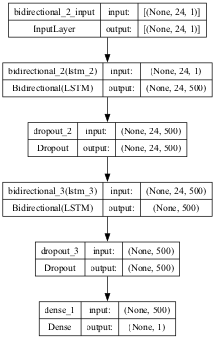

In [ ]:
# Plotting the model architecture

plot_model(model, to_file='bilstm_gbdt.png', show_shapes=True, show_layer_names=True, dpi=50)


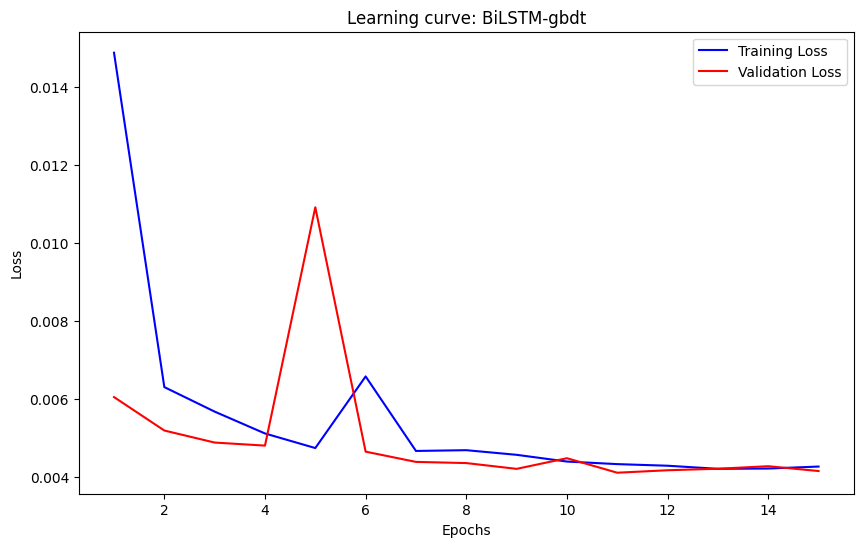

In [ ]:
plot_learning_curve(history_gbdt, 'BiLSTM-gbdt')

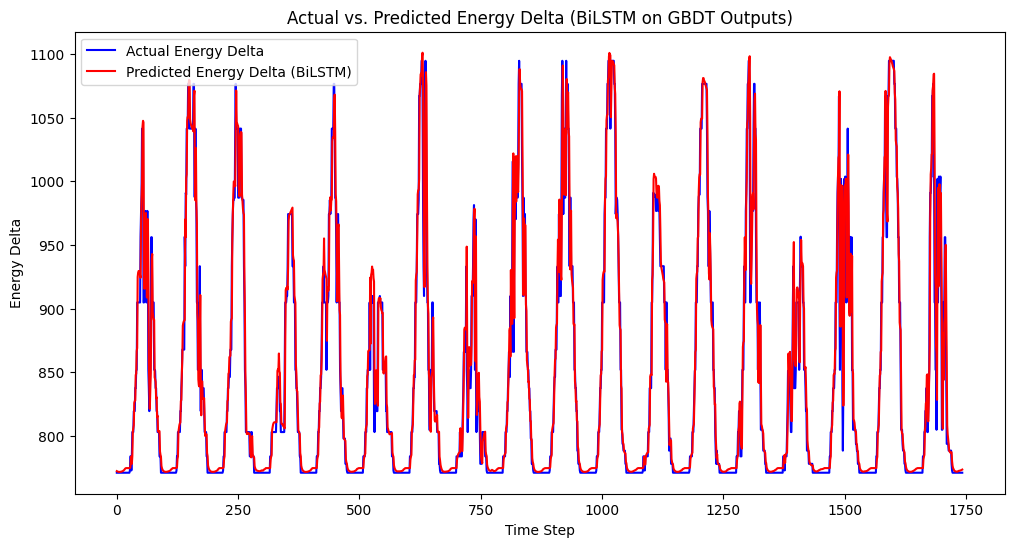

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_gbdt_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_gbdt, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on GBDT Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data

xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
xgb_output_train = xgb.predict(X_train)
xgb_output_test = xgb.predict(X_test)

evaluate_model(y_train, xgb_output_train, 'XGB', 'Training')
evaluate_model(y_test, xgb_output_test, 'XGB', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

xgb_output_train_scaled = scaler.fit_transform(xgb_output_train.reshape(-1, 1))
xgb_output_test_scaled = scaler.transform(xgb_output_test.reshape(-1, 1))


# Create BiLSTM input for all three model outputs

X_train_bilstm_xgb, y_train_bilstm_xgb = create_dataset(xgb_output_train_scaled, time_step)
X_test_bilstm_xgb, y_test_bilstm_xgb = create_dataset(xgb_output_test_scaled, time_step)

X_train_bilstm_xgb = X_train_bilstm_xgb.reshape(X_train_bilstm_xgb.shape[0], time_step, 1)
X_test_bilstm_xgb = X_test_bilstm_xgb.reshape(X_test_bilstm_xgb.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs

print("Training BiLSTM on XGB outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_xgb = model.fit(X_train_bilstm_xgb, y_train_bilstm_xgb, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_xgb, y_test_bilstm_xgb), verbose=1)

# Step 7: Predict with BiLSTM

y_pred_bilstm_xgb_scaled = model.predict(X_test_bilstm_xgb)
y_pred_bilstm_xgb = scaler.inverse_transform(y_pred_bilstm_xgb_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_xgb_actual_rescaled = scaler.inverse_transform(y_test_bilstm_xgb.reshape(-1, 1))

evaluate_model(y_test_bilstm_xgb_actual_rescaled, y_pred_bilstm_xgb, 'BiLSTM (XGB)', 'Testing')

dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on XGB outputs...


Epoch 1/15
111/111 [==============================] - 14s 116ms/step - loss: 0.0143 - val_loss: 0.0071
Epoch 2/15
111/111 [==============================] - 14s 130ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 3/15
111/111 [==============================] - 14s 129ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 4/15
111/111 [==============================] - 14s 125ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 5/15
111/111 [==============================] - 15s 132ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/15
111/111 [==============================] - 15s 131ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/15
111/111 [==============================] - 15s 135ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/15
111/111 [==============================] - 15s 131ms/step - loss: 0.0044 - val_loss: 0.0133
Epoch 9/15
111/111 [==============================] - 15s 131ms/step - loss: 0.0052 - val_lo

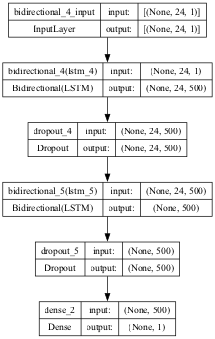

In [ ]:
# Plotting the model architecture
plot_model(model, to_file='bilstm_xgb.png', show_shapes=True, show_layer_names=True, dpi=50)

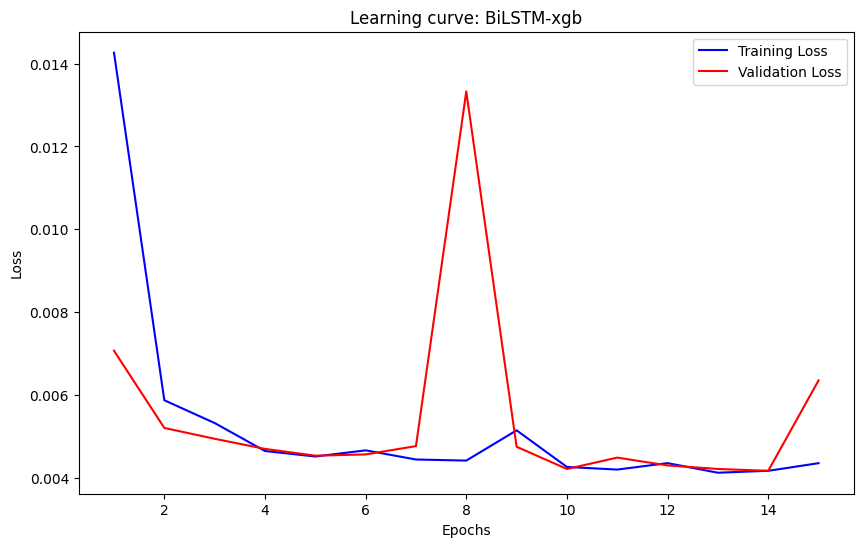

In [ ]:
plot_learning_curve(history_xgb, 'BiLSTM-xgb')

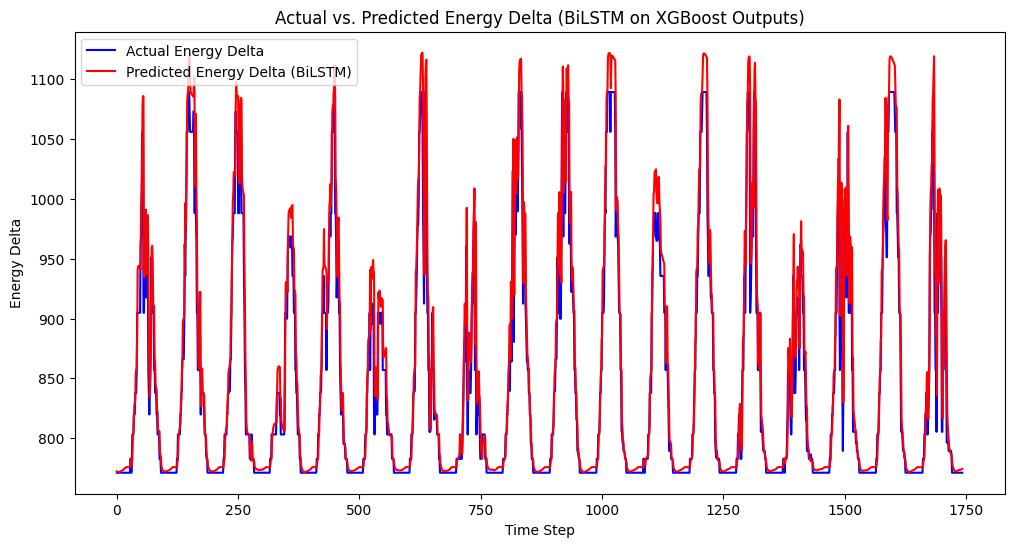

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_xgb_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_xgb, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on XGBoost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5)

catboost.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
catboost_output_train = catboost.predict(X_train)
catboost_output_test = catboost.predict(X_test)

# Evaluate model performance on training and test sets 
evaluate_model(y_train, catboost_output_train, 'Catboost', 'Training')
evaluate_model(y_test, catboost_output_test, 'Catboost', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

catboost_output_train_scaled = scaler.fit_transform(catboost_output_train.reshape(-1, 1))
catboost_output_test_scaled = scaler.transform(catboost_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_catboost, y_train_bilstm_catboost = create_dataset(catboost_output_train_scaled, time_step)
X_test_bilstm_catboost, y_test_bilstm_catboost = create_dataset(catboost_output_test_scaled, time_step)

X_train_bilstm_catboost = X_train_bilstm_catboost.reshape(X_train_bilstm_catboost.shape[0], time_step, 1)
X_test_bilstm_catboost = X_test_bilstm_catboost.reshape(X_test_bilstm_catboost.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on CatBoost outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_catboost = model.fit(X_train_bilstm_catboost, y_train_bilstm_catboost, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_catboost, y_test_bilstm_catboost), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_catboost_scaled = model.predict(X_test_bilstm_catboost)
y_pred_bilstm_catboost = scaler.inverse_transform(y_pred_bilstm_catboost_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_catboost_actual_rescaled = scaler.inverse_transform(y_test_bilstm_catboost.reshape(-1, 1))

evaluate_model(y_test_bilstm_catboost_actual_rescaled, y_pred_bilstm_catboost, 'BiLSTM (CatBoost)', 'Testing')

0:	learn: 1169.0946685	total: 60.8ms	remaining: 6.02s
1:	learn: 1168.0925272	total: 61.6ms	remaining: 3.02s
2:	learn: 1167.1084474	total: 62.2ms	remaining: 2.01s
3:	learn: 1166.1101742	total: 62.8ms	remaining: 1.51s
4:	learn: 1165.1298663	total: 63.5ms	remaining: 1.21s
5:	learn: 1164.1408403	total: 64ms	remaining: 1s
6:	learn: 1163.1617526	total: 64.6ms	remaining: 859ms
7:	learn: 1162.1639709	total: 65.1ms	remaining: 749ms
8:	learn: 1161.1852677	total: 65.7ms	remaining: 664ms
9:	learn: 1160.2169376	total: 66.2ms	remaining: 596ms
10:	learn: 1159.2356772	total: 66.8ms	remaining: 540ms
11:	learn: 1158.2490492	total: 67.3ms	remaining: 494ms
12:	learn: 1157.2513880	total: 67.9ms	remaining: 454ms
13:	learn: 1156.2673679	total: 68.4ms	remaining: 420ms
14:	learn: 1155.3003584	total: 69.1ms	remaining: 392ms
15:	learn: 1154.3299804	total: 69.8ms	remaining: 366ms
16:	learn: 1153.3389060	total: 70.5ms	remaining: 344ms
17:	learn: 1152.3799063	total: 71.2ms	remaining: 324ms
18:	learn: 1151.3939221	t

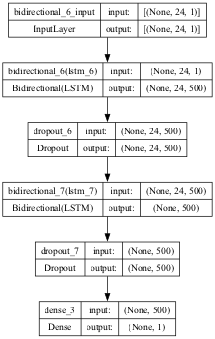

In [ ]:
plot_model(model, to_file='bilstm_catboost.png', show_shapes=True, show_layer_names=True, dpi=50)


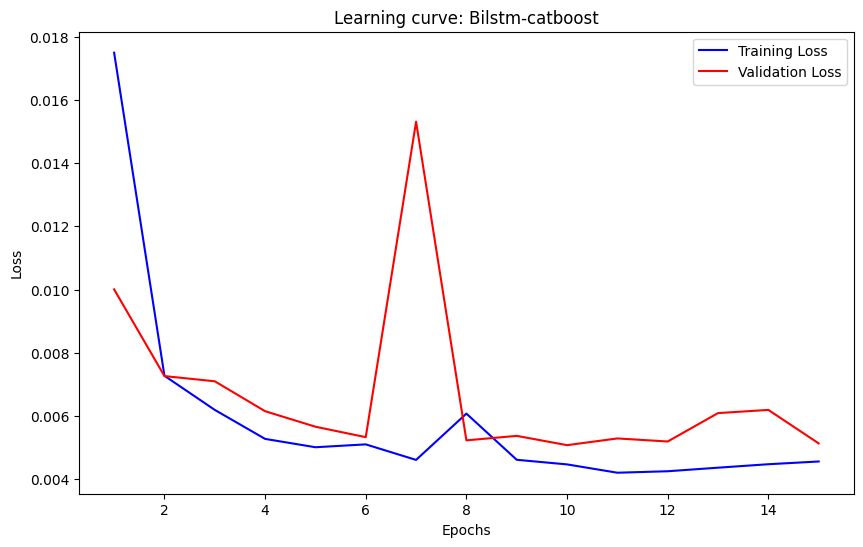

In [ ]:
plot_learning_curve(history_catboost, 'Bilstm-catboost')

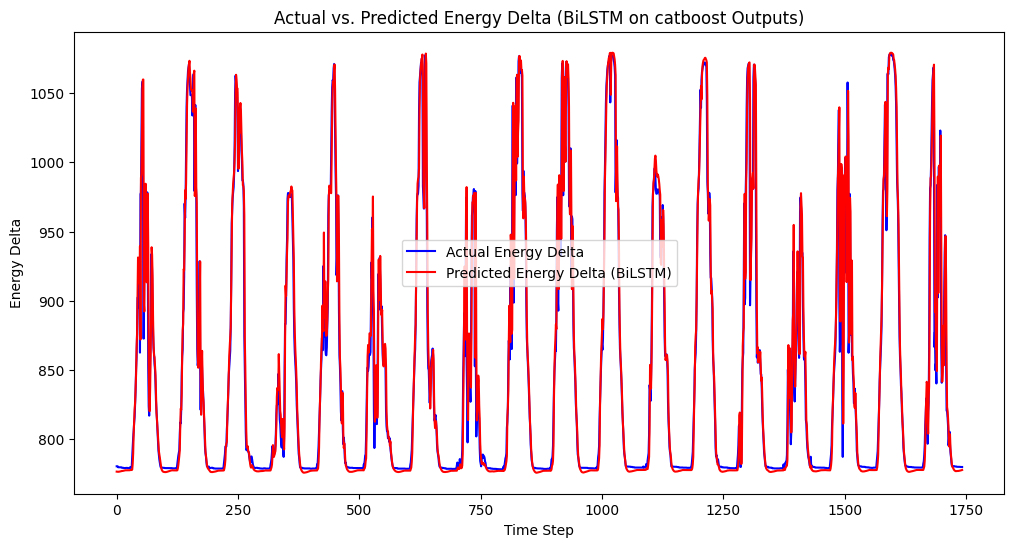

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_catboost_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_catboost, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on catboost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

lgbm.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
lgbm_output_train = lgbm.predict(X_train)
lgbm_output_test = lgbm.predict(X_test)


# Evaluate model performance on training and test sets
evaluate_model(y_train, lgbm_output_train, 'LightGBM', 'Training')
evaluate_model(y_test, lgbm_output_test, 'LightGBM', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
lgbm_output_train_scaled = scaler.fit_transform(lgbm_output_train.reshape(-1, 1))
lgbm_output_test_scaled = scaler.transform(lgbm_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_lgbm, y_train_bilstm_lgbm = create_dataset(lgbm_output_train_scaled, time_step)
X_test_bilstm_lgbm, y_test_bilstm_lgbm = create_dataset(lgbm_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_lgbm = X_train_bilstm_lgbm.reshape(X_train_bilstm_lgbm.shape[0], time_step, 1)
X_test_bilstm_lgbm = X_test_bilstm_lgbm.reshape(X_test_bilstm_lgbm.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_lgbm = model.fit(X_train_bilstm_lgbm, y_train_bilstm_lgbm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_lgbm, y_test_bilstm_lgbm), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_lgbm_scaled = model.predict(X_test_bilstm_lgbm)
y_pred_bilstm_lgbm = scaler.inverse_transform(y_pred_bilstm_lgbm_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_lgbm_actual_rescaled = scaler.inverse_transform(y_test_bilstm_lgbm.reshape(-1, 1))
evaluate_model(y_test_bilstm_lgbm_actual_rescaled, y_pred_bilstm_lgbm, 'BiLSTM (LightGBM)', 'Testing')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 7065, number of used features: 4
[LightGBM] [Info] Start training from score 852.045718
dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/15
111/111 [==============================] - 14s 111ms/step - loss: 0.0157 - val_loss: 0.0066
Epoch 2/15
111/111 [==============================] - 14s 124ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 3/15
111/111 [==============================] - 14s 125ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 4/15
111/111 [==============================] - 14s 127ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 5/15
111/111 [==============================] - 14s 124ms/step - loss: 0.0044 - val_loss: 0.

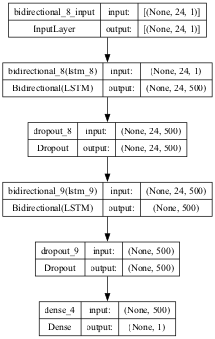

In [ ]:
plot_model(model, to_file='bilstm_lightgbm.png', show_shapes=True, show_layer_names=True, dpi=50)

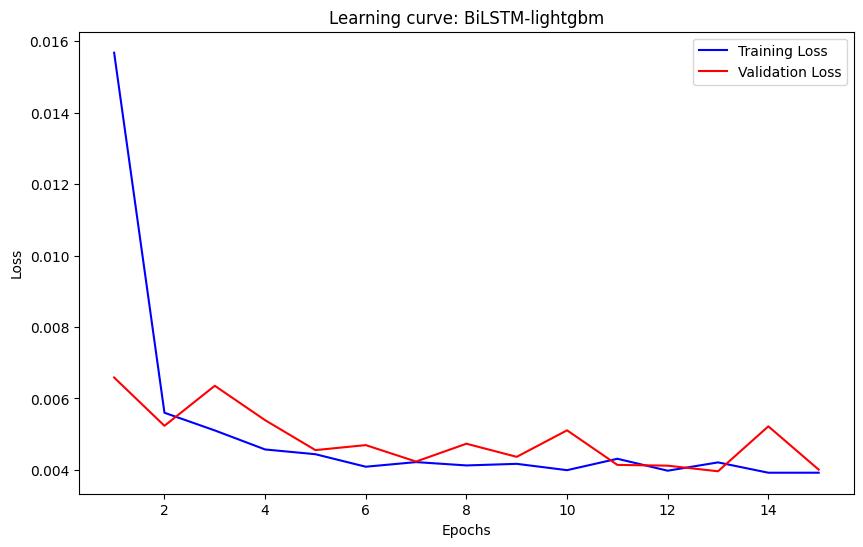

In [ ]:
plot_learning_curve(history_lgbm, 'BiLSTM-lightgbm')

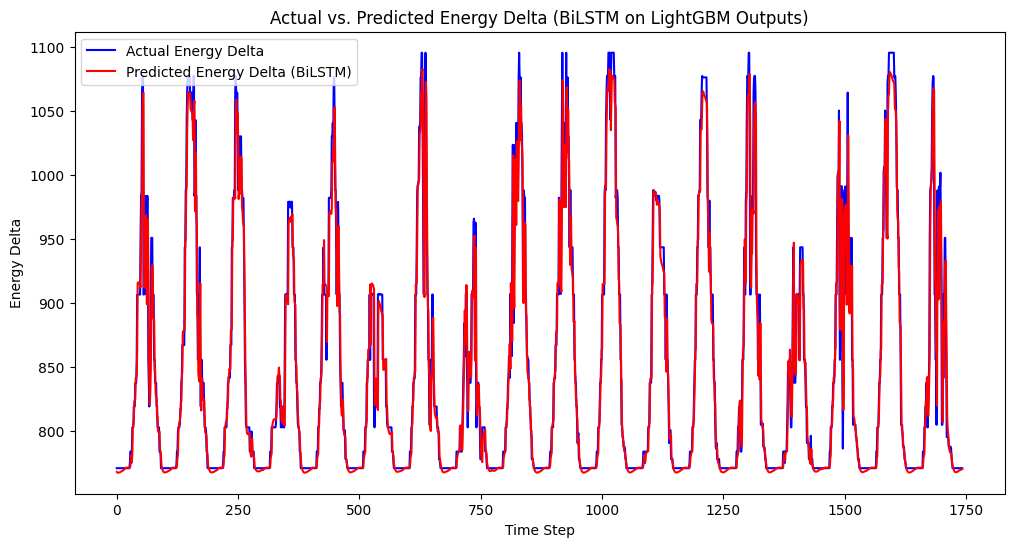

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_lgbm_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_lgbm, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on LightGBM Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [ ]:
results_df = pd.DataFrame(evaluation_results)
print("\nevaluation metrics table: ")


evaluation metrics table: 


In [ ]:
results_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,167.318890,1.116724e+05,334.174260,0.918587
1,BiLSTM,Testing,180.141856,1.208240e+05,347.597479,0.900717
2,GBDT,Training,860.401897,1.144981e+06,1070.037900,0.163687
3,GBDT,Testing,836.409249,1.030336e+06,1015.054721,0.153355
4,BiLSTM (GBDT),Testing,12.726787,5.440484e+02,23.324845,0.938934
5,XGB,Training,860.634503,1.146407e+06,1070.704047,0.162645
6,XGB,Testing,836.155556,1.028978e+06,1014.385500,0.154472
7,BiLSTM (XGB),Testing,16.617725,7.962274e+02,28.217501,0.911979
8,Catboost,Training,864.050374,1.157826e+06,1076.023293,0.154304
9,Catboost,Testing,838.195377,1.033128e+06,1016.428878,0.151062


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
